# Quantum-like Analysis

In [2]:
import os
import numpy as np

# Constants
BASE_PATH = '/home/vincent/AAA_projects/MVCS/Neuroscience/'
EEG_PATH = os.path.join(BASE_PATH, 'eeg_data_with_channels.npy')
OUTPUT_PATH = os.path.join(BASE_PATH, 'Analysis/Quantum_Analysis/coherences.npy')

# List of EEG channels
EEG_CHANNELS = [
    'Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
    'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2'
]

def load_or_simulate_eeg_data(path, num_samples, num_channels):
    """
    Load EEG data if it exists, otherwise simulate some data.
    """
    if os.path.exists(path):
        return np.load(path, allow_pickle=True)
    else:
        return np.random.rand(num_samples, num_channels)

def construct_density_matrix(data):
    """
    Constructs a Hermitian density matrix from data.
    """
    prob_dist = data / (np.sum(data) + 1e-10)  # Avoid division by zero with a small constant
    density_matrix = np.outer(prob_dist, prob_dist)
    # Make it Hermitian
    return 0.5 * (density_matrix + density_matrix.T)

def calculate_coherence(rho):
    """
    Calculates coherence from a density matrix.
    """
    eigenvalues = np.linalg.eigvals(rho)
    sorted_eigenvalues = np.sort(np.abs(eigenvalues))
    # Subtract the sum of all eigenvalues from the sum of the largest ones
    l1_norm = np.sum(sorted_eigenvalues) - np.sum(sorted_eigenvalues[-2:]) 
    return l1_norm

def main():
    # Load or simulate EEG data
    EEG_data = load_or_simulate_eeg_data(EEG_PATH, 1000, len(EEG_CHANNELS))

    # Calculate "quantum coherence" for each EEG sample
    coherences = [
        calculate_coherence(construct_density_matrix(sample))
        for sample in EEG_data
    ]

    # Save the results
    os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
    np.save(OUTPUT_PATH, coherences)

    # Display the results
    for idx, coherence in enumerate(coherences):
        print(f"Sample {idx+1}: {coherence}")

if __name__ == "__main__":
    main()

# Quantum-like Entanglement

In [ ]:
import numpy as np
import os

# Example EEG data
num_samples = 1000
num_channels = len(eeg_channels)
EEG_data = np.random.rand(num_samples, num_channels)

def construct_joint_density_matrix(data1, data2):
    """
    Constructs a joint density matrix from two datasets.
    """
    prob_dist1 = data1 / np.sum(data1)
    prob_dist2 = data2 / np.sum(data2)
    joint_prob_dist = np.outer(prob_dist1, prob_dist2)
    return joint_prob_dist

def von_neumann_entropy(rho):
    """
    Calculates the Von Neumann entropy from a density matrix.
    """
    eigenvalues = np.linalg.eigvals(rho)
    eigenvalues = eigenvalues[eigenvalues > 0]  # Remove non-positive eigenvalues
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    return entropy

coherences = []

# Calculate the quantum-like coherence measure for each EEG sample
for sample in range(num_samples):
    entropy_values = []
    
    for channel in range(num_channels):
        rho = construct_density_matrix(EEG_data[sample, channel])
        entropy = von_neumann_entropy(rho)
        entropy_values.append(entropy)
        
    joint_entropies = []
    
    for ch1 in range(num_channels):
        for ch2 in range(ch1+1, num_channels):  # Pairwise combinations
            joint_rho = construct_joint_density_matrix(EEG_data[sample, ch1], EEG_data[sample, ch2])
            joint_entropy = von_neumann_entropy(joint_rho)
            joint_entropies.append(joint_entropy)
    
    # Define coherence as average entropy difference
    average_entropy = np.mean(entropy_values)
    average_joint_entropy = np.mean(joint_entropies)
    coherence = average_joint_entropy - 2 * average_entropy  # Factor of 2 due to bipartite system
    coherences.append(coherence)

coherences = []

# Loop over each EEG channel
for channel in range(num_channels):
    entropy_values = []

    # Calculate the entropy for the current channel
    for sample in range(num_samples):
        rho = construct_density_matrix(EEG_data[sample, channel])
        entropy = von_neumann_entropy(rho)
        entropy_values.append(entropy)

    # Calculate the average entropy for the current channel
    average_entropy = np.mean(entropy_values)

    # Calculate coherence for the current channel
    coherence = average_joint_entropy - 2 * average_entropy  # Similar to previous formula
    coherences.append(coherence)

# Save the results
output_path = "/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Quantum_Analysis/coherences.npy"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
np.save(output_path, coherences)

# Print the calculated coherences
print("Quantum Coherence Values:")
for idx, coherence in enumerate(coherences):
    print(f"Sample {idx+1}: {coherence}")

# Hermitian

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Constants
BASE_PATH = '/home/vincent/AAA_projects/MVCS/Neuroscience/'
EEG_PATH = os.path.join(BASE_PATH, 'eeg_data_with_channels.npy')
SAVE_PATH = os.path.join(BASE_PATH, 'Analysis/Quantum_Analysis/')
EEG_CHANNELS = [
    'Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
    'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2'
]

downsample_factor = 1000

def wave_function(data):
    magnitude = np.linalg.norm(data, axis=-1, keepdims=True)
    return np.exp(-1j * data) / magnitude

def hermitian_operator(data):
    data_conj = np.conj(data)
    return np.outer(data, data_conj)

def expectation_value(state, operator):
    state_conj = np.conj(state).flatten()
    return np.real(np.dot(state_conj, np.dot(operator, state)))

def normalize(psi):
    return psi / np.sqrt(np.sum(np.conj(psi) * psi, axis=1, keepdims=True))

def matrix_element(psi1, H, psi2):
    return np.dot(psi1, np.dot(H, psi2))

def downsample_data(data, factor=10):
    num_samples = data.shape[0] // factor
    return np.mean(data[:num_samples*factor].reshape((num_samples, factor, -1)), axis=1)

def process_channel(ch_data):
    quantum_states_downsampled = wave_function(ch_data)
    normalized_states_downsampled = normalize(quantum_states_downsampled)
    H = hermitian_operator(ch_data.flatten())  # Flatten before computing the Hermitian
    eigen_values, _ = np.linalg.eigh(H)
    exp_val_ch = expectation_value(normalized_states_downsampled.flatten(), H)  # Flatten for the expectation calculation
    return eigen_values, H, matrix_element(normalized_states_downsampled.flatten(), H, quantum_states_downsampled.flatten()), exp_val_ch

try:
    eeg_data = np.load(EEG_PATH)
    results = Parallel(n_jobs=-1)(delayed(process_channel)(downsample_data(eeg_data[:, ch], downsample_factor)) for ch in range(eeg_data.shape[1]))
    eigen_data, hermitian_matrices, matrix_elements, exp_val_list = zip(*results)

    fig, axes = plt.subplots(len(EEG_CHANNELS), 1, figsize=(10, 5 * len(EEG_CHANNELS)))
    for ch, ax in enumerate(axes):
        ax.plot(eigen_data[ch], label="Eigenvalues")
        ax.plot(exp_val_list[ch], label="Expectation values", linestyle='--')
        ax.set_title(EEG_CHANNELS[ch])
        ax.legend()
    plt.tight_layout()

    if not os.path.exists(SAVE_PATH):
        os.makedirs(SAVE_PATH)
    plt.savefig(os.path.join(SAVE_PATH, 'quantum_analysis_plot.png'))

    for data, name in zip([eigen_data, hermitian_matrices, exp_val_list, matrix_elements], ['eigen_data', 'hermitian_matrices', 'expectation_values', 'matrix_elements']):
        np.save(os.path.join(SAVE_PATH, name + '.npy'), data)

except Exception as e:
    print(f"An error occurred: {e}")

# Print and plot

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Constants
BASE_PATH = '/home/vincent/AAA_projects/MVCS/Neuroscience/'
SAVE_PATH = os.path.join(BASE_PATH, 'Analysis/Quantum_Analysis/')
EEG_CHANNELS = [
    'Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
    'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
    'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2'
]

# Load saved results
quantum_states = np.load(os.path.join(SAVE_PATH, 'quantum_states.npy'))
hermitian_matrices = np.load(os.path.join(SAVE_PATH, 'hermitian_matrices.npy'))
exp_val = np.load(os.path.join(SAVE_PATH, 'expectation_values.npy'))
normalized_states = np.load(os.path.join(SAVE_PATH, 'normalized_states.npy'))
eigen_data = np.load(os.path.join(SAVE_PATH, 'eigen_data.npy'))
matrix_elements = np.load(os.path.join(SAVE_PATH, 'matrix_elements.npy'))

# Display results
print("Quantum States: ", quantum_states)
print("Hermitian Matrices: ", hermitian_matrices)
print("Expectation Values: ", exp_val)
print("Normalized States: ", normalized_states)
print("Eigen Data: ", eigen_data)
print("Matrix Elements: ", matrix_elements)

# Plot if you saved the figure
img_path = os.path.join(SAVE_PATH, 'quantum_analysis_plot.png')
if os.path.exists(img_path):
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.show()
else:
    print("Image not found!")

In [5]:
# Calculate magnitude and phase
magnitudes = np.abs(exp_val)
phases = np.angle(exp_val)

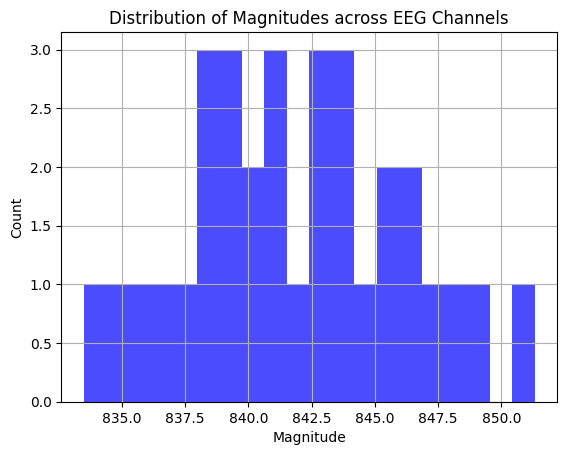

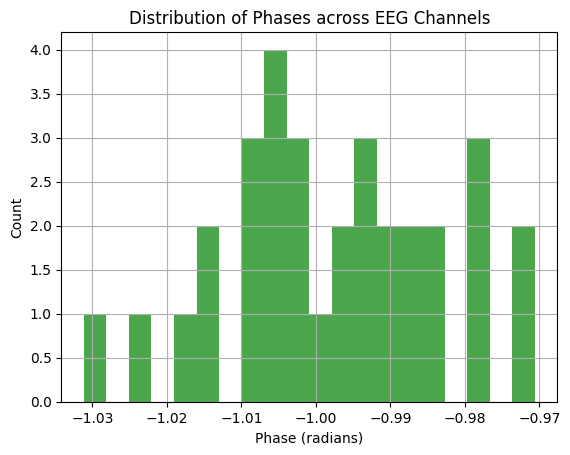

In [6]:
import matplotlib.pyplot as plt

# Histogram for Magnitudes
plt.figure()
plt.hist(magnitudes, bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Magnitudes across EEG Channels")
plt.xlabel("Magnitude")
plt.ylabel("Count")
plt.grid(True)

# Histogram for Phases
plt.figure()
plt.hist(phases, bins=20, color='green', alpha=0.7)
plt.title("Distribution of Phases across EEG Channels")
plt.xlabel("Phase (radians)")
plt.ylabel("Count")
plt.grid(True)

plt.show()

In [ ]:
import mne
import matplotlib.pyplot as plt

# Assuming you've already separated the exp_val into magnitude and phase
magnitudes = np.abs(exp_val)
phases = np.angle(exp_val)

# Create an MNE Info structure
info = mne.create_info(ch_names=EEG_CHANNELS, sfreq=1000.0, ch_types='eeg')

# Create evoked data structure for magnitudes
evoked_magnitudes = mne.EvokedArray(magnitudes[:, np.newaxis], info)

# Plot the topomap for magnitudes
evoked_magnitudes.plot_topomap(times=[0], ch_type='eeg')
plt.title("Topomap for Magnitudes")
plt.show()

# Create evoked data structure for phases
evoked_phases = mne.EvokedArray(phases[:, np.newaxis], info)

# Plot the topomap for phases
evoked_phases.plot_topomap(times=[0], ch_type='eeg')
plt.title("Topomap for Phases")
plt.show()

In [ ]:
def hermitian_operator(data):
    """Construct the Hermitian operator from EEG data for an individual channel."""
    return data @ np.conj(data).T

hermitian_matrices = [hermitian_operator(eeg_data[ch]) for ch in range(n_channels)]

# Quantum Dynamics Simulation

In [ ]:
print(eeg_data.shape[0])

In [ ]:
from scipy.linalg import expm

def hermitian_operator(data):
    """Construct the Hermitian operator from EEG data for an individual channel."""
    return data @ np.conj(data).T

# Assuming eeg_data has channels as rows and time samples as columns
n_channels = eeg_data.shape[0]

# Using the previous computation for Hermitian matrices
hermitian_matrices = [hermitian_operator(eeg_data[ch, :]) for ch in range(n_channels)]

def evolve_state(initial_state, hamiltonian, t):
    """Evolve the quantum state using the given Hamiltonian and time duration."""
    return np.dot(expm(-1j * hamiltonian * t), initial_state)

# Let's evolve our EEG-derived quantum states for a given time t
t = 1.0  # You can adjust this as needed
evolved_states = [evolve_state(quantum_states[ch], hermitian_matrices[ch], t) for ch in range(n_channels)]

In [13]:
def hermitian_operator(data):
    """Construct the Hermitian operator from EEG data for an individual channel."""
    return data @ np.conj(data).T

hermitian_matrices = [hermitian_operator(eeg_data[ch]) for ch in range(n_channels)]

def print_head(matrix_or_vector, num=5):
    """Print the first few rows of a matrix or vector."""
    if len(matrix_or_vector.shape) == 1:  # It's a vector
        for i in range(min(num, len(matrix_or_vector))):
            print(matrix_or_vector[i])
    else:  # It's a matrix
        for i in range(min(num, len(matrix_or_vector))):
            print(matrix_or_vector[i][:num])
    print("\n")

# Eigendecomposition of Hermitian Matrices

In [ ]:
def eigendecompose(matrix):
    """Compute the eigendecomposition of a matrix."""
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    return eigenvalues, eigenvectors

# Eigendecomposition for each channel's Hermitian matrix
eigenvalues_list = []
eigenvectors_list = []

for matrix in hermitian_matrices:
    eigenvalues, eigenvectors = eigendecompose(matrix)
    eigenvalues_list.append(eigenvalues)
    eigenvectors_list.append(eigenvectors)

In [ ]:
print("Head of the Hermitian matrices results:")
for ch, matrix in zip(EEG_CHANNELS, hermitian_matrices):
    print(f"Channel: {ch}")
    print_head(matrix)

print("Head of the evolved_states results:")
for ch, state in zip(EEG_CHANNELS, evolved_states):
    print(f"Channel: {ch}")
    print_head(state)

print("Head of the eigenvalues from eigendecomposition results:")
for ch, eigenvalues in zip(EEG_CHANNELS, eigenvalues_list):
    print(f"Channel: {ch}")
    print_head(eigenvalues)

print("Head of the eigenvectors from eigendecomposition results:")
for ch, eigenvectors in zip(EEG_CHANNELS, eigenvectors_list):
    print(f"Channel: {ch}")
    print_head(eigenvectors)